In [10]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from os.path import join
import time
from random import sample
import math

In [11]:
data = []
data += [["data/1.jpg", "data/2.jpg"]]
data += [["data/hill1.JPG", "data/hill2.JPG"]]
data += [["data/S1.jpg", "data/S2.jpg"]]

In [12]:
def Matcher(features1,features2):
    matches = []
    for idx1, f1 in enumerate(features1):
        f1 = np.repeat([f1], len(features2), axis=0)
        diff = np.power((features2 - f1), 2).sum(axis = 1)
        d1, d2 = np.partition(diff, 2)[0:2]
        if d1 / d2 < 0.7:
            matches.append(cv2.DMatch(idx1, np.argmin(diff), d1))
    matches =sorted(matches, key=lambda x:x.distance)
    return matches

In [13]:
def homomat(obj_points, img_points):
    A = []
    for i in range(obj_points.shape[0]):
        u1, v1 = obj_points[i]
        u2, v2 = img_points[i]
        A.append([u1, v1, 1, 0, 0, 0, -u1 * u2, -u2 * v1, -u2])
        A.append([0, 0, 0, u1, v1, 1, -u1 * v2, -v2 * v1, -v2])   
    A = np.array(A)
    _, _, vt = np.linalg.svd(A)

    x = vt[-1]
    x = x / x[-1]
    x = x.reshape(3,3)
    return x

def score(H, k1, k2, threshold):
    inliner = 0
    for i in range(len(k1)):
        k = H @ k1[i]
        if k[-1] == 0:
            continue
        k = (k/k[-1])[0:-1]
        if np.power((k - k2[i]), 2).sum() < threshold:
            inliner += 1
    return inliner

def RANSAC(kp1, kp2, iteration, threshold):
    H_all = []
    idx_list = range(len(kp1))
    for _ in range(iteration):
        sample_point1 = []
        sample_point2 = []
        for idx in sample(idx_list, 4):
            sample_point1 += [kp1[idx]]
            sample_point2 += [kp2[idx]]
        H_all.append(homomat(np.array(sample_point1), np.array(sample_point2)))

    ones = np.ones((len(kp1),1))
    homo_kp1 = np.concatenate((kp1,ones), axis = 1)
    inliner = 0
    print("scoring")
    for H in H_all:
        s = score(H, homo_kp1, kp2, threshold)
        if inliner < s:
            inliner = s
            best_H = H
    print("inliner: ", inliner)
    return best_H

In [14]:
def boundary(H, a, b):
    corners = np.array([[0, 0, 1],
                    [0, a, 1],
                    [b, 0, 1],
                    [b, a, 1]])
    corners = H @ corners.T
    corners = (corners/corners[-1])[0:2]
    min_x = corners[0].min()
    max_x = corners[0].max()
    min_y = corners[1].min()
    max_y = corners[1].max()
    return int(min_x), int(max_x), int(min_y), int(max_y)
    
def warp(img1, img2, H):
    min_x, max_x, min_y, max_y = boundary(H, img1.shape[0], img1.shape[1])
    max_x = max(max_x, img2.shape[1])
    max_y = max(max_y, img2.shape[0])
    result = np.zeros((max_y-min_y, max_x-min_x, 3), dtype = np.uint8)
    result[-min_y: img2.shape[0]-min_y, -min_x: img2.shape[1]-min_x]= img2
    
    H_inv = np.linalg.inv(H)
    h ,w, _ = img1.shape
    for i in range (result.shape[1]):
        for j in range (result.shape[0]):
            pos = H_inv @ [[i+min_x], [j+min_y], [1]]
            x, y = (pos/pos[-1])[0:-1]
            int_x = int(x)
            int_y = int(y)
            
            #interpolation
            '''
            if (int_x > 0) and (int_x < w-1) and (int_y > 0) and (int_y < h-1):
                r1 = ((x - int_x)*img1[int_y][int_x]) + ((int_x + 1 - x)*img1[int_y][int_x+1])
                r2 = ((x - int_x)*img1[int_y+1][int_x]) + ((int_x + 1 - x)*img1[int_y+1][int_x+1])
                result[j][i] = (y - int_y)*r1 + (int_y + 1 - y)*r2
            '''
            #w/o blending
            '''
            if (x > 0) and (x < w) and (y > 0) and (y < h):
                result[j][i] = img1[int_y][int_x]
            '''
            #blending
            if (x >= 0) and (x < w) and (y >= 0) and (y < h):
                if result[j][i].all() != 0:
                    # x
                    dx1 = w - x
                    dx2 = i - (-min_x)
                    
                    # linear
                    w1 = dx1 / (dx1 + dx2)
                    w2 = dx2 / (dx1 + dx2)
                    
                    # bilinear
                    # y
                    '''
                    dy1 = min(h - y, y - 0)
                    dy2 = min(j - (-min_y), (img2.shape[0] - min_y) - j)
                    rx1 = dx1 / (dx1 + dx2)
                    ry1 = dy1 / (dy1 + dy2)
                    r1 = rx1 * ry1
                    r2 = (1 - rx1) * (1 - ry1)
                    w1 = r1 / (r1 + r2)
                    w2 = r2 / (r1 + r2)
                    '''                   

                    result[j][i] = (w1 * img1[int_y][int_x] + w2 * result[j][i])
                else:
                    result[j][i] = img1[int_y][int_x]
    return result

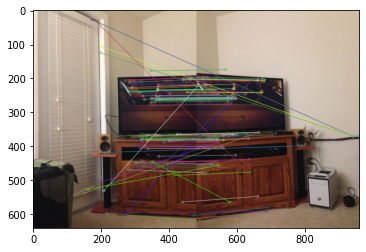

num of kp:  138
scoring
inliner:  94


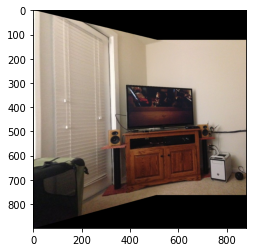

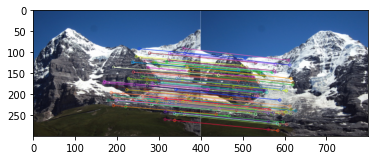

num of kp:  564
scoring
inliner:  537


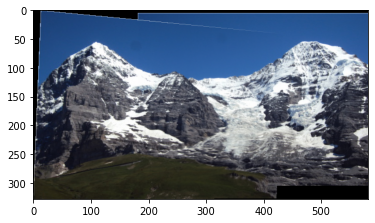

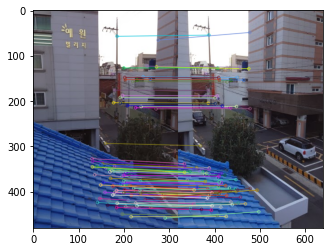

num of kp:  376
scoring
inliner:  269


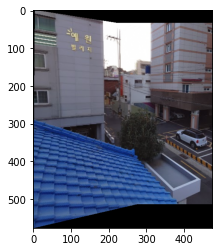

In [15]:
for idx, im_pair in enumerate(data):
    img1 = cv2.imread(im_pair[0])
    img2 = cv2.imread(im_pair[1])
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    #SIFT
    sift = cv2.xfeatures2d.SIFT_create()
    (keypoints1, features1) = sift.detectAndCompute(gray1, None)
    (keypoints2, features2) = sift.detectAndCompute(gray2, None)
    
    #feature matching
    matches = Matcher(features1,features2)
    img3 = cv2.drawMatches(img1, keypoints1, img2, keypoints2, matches[:100], img2, flags=2)
    #cv2.imwrite("keypoint"+str(idx)+".jpg", img3)
    plt.imshow(img3[:,:,::-1])
    plt.show()
    
    goodkp1 = [list(keypoints1[x.queryIdx].pt) for x in matches]
    goodkp2 = [list(keypoints2[x.trainIdx].pt) for x in matches]
    print("num of kp: ", len(goodkp1))
    
    #find homography using RANSAC
    best_H = RANSAC(goodkp1, goodkp2, 200, 8)
    
    #warp image
    result = warp(img1, img2, best_H)
    #cv2.imwrite("result"+str(idx)+".jpg", result)
    plt.imshow(result[:,:,::-1])
    plt.show()